In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

# 🏢 Chicago Salaries 💰

Chicago has public data on many job salaries of public servant type roles.  This data can be found [here](https://data.cityofchicago.org/Administration-Finance/Current-Employee-Names-Salaries-and-Position-Title/xzkq-xp2w).

### Warm Up 🥵

* What are C and epsilon used for in SVR?

----

#### Boosting 🚀

Boosting is an 'ensembling' technique.

What does ensembling mean in the context of machine learning?

In boosting, we'll iteratively build models (aka build models in a series; aka build one model after another). The overview is.

1. Build a pretty dumb model (more typically called a 'weak learner')
   * In the image doing classification, this is the first grid
* See where that model makes mistakes
* Build another model with a focus on not making the same mistakes again
   * In the image, this is the second/third grids.  The mistakes are enlarged in these to show that they're a priority.
* Repeat steps 1-3 as much as you want
* Combine the output of these models somehow
   * In the image, this is the final grid.


<img src='https://d1jnx9ba8s6j9r.cloudfront.net/blog/wp-content/uploads/2019/06/How-Does-Boosting-Algorithm-Work-Boosting-Machine-Learning-Edureka-min-528x254.png' width='50%'>

----

This image is more focused on boosting in a regression setting.

<p align='center'><img src='https://i.imgur.com/RewteYv.png' width=70%></p>

## Data Import and EDA

In [2]:
# !pip install gender_guesser
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

from category_encoders import LeaveOneOutEncoder
from sklearn.pipeline import Pipeline

from gender_guesser.detector import Detector

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
# This is a direct link to the published data.
# The data might change (last updated Oct 2019)
# The data might be moved and this link might break
# A snapshot of the data can be found on kaggle:
# https://www.kaggle.com/chicago/chicago-citywide-payroll-data

# The commentary in this notebook also falls out of date pretty quickly... sorry
data_url = (
    "https://data.cityofchicago.org/api/views/xzkq-xp2w/rows.csv?accessType=DOWNLOAD"
)
chicago = pd.read_csv(data_url)

<IPython.core.display.Javascript object>

Do some general 'get to know you' EDA

In [4]:
chicago.shape

(33702, 8)

<IPython.core.display.Javascript object>

In [5]:
chicago.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33702 entries, 0 to 33701
Data columns (total 8 columns):
Name                 33702 non-null object
Job Titles           33702 non-null object
Department           33702 non-null object
Full or Part-Time    33702 non-null object
Salary or Hourly     33702 non-null object
Typical Hours        8174 non-null float64
Annual Salary        25528 non-null float64
Hourly Rate          8174 non-null float64
dtypes: float64(3), object(5)
memory usage: 2.1+ MB


<IPython.core.display.Javascript object>

If you didn't already run an `np.nan` check, do one now to show the percent of missing values by column

In [6]:
chicago.head()

,Name,Job Titles,Department,Full or Part-Time,Salary or Hourly,Typical Hours,Annual Salary,Hourly Rate
0,"ADRIANO, RACQUEL ANNE",PARAMEDIC,FIRE,F,Salary,NaN,72510.0,NaN
1,"AFFANEH, MAHIR A",POLICE OFFICER,POLICE,F,Salary,NaN,93354.0,NaN
2,"AFOENYI, PHYLLIS",TITLE V PROGRAM TRAINEE I,FAMILY & SUPPORT,P,Hourly,20.0,NaN,13.0
3,"AGAR, BULENT B",DEPUTY COMMISSIONER,WATER MGMNT,F,Salary,NaN,132972.0,NaN
4,"AGEE, LAWRENCE",POLICE OFFICER,POLICE,F,Salary,NaN,90024.0,NaN


<IPython.core.display.Javascript object>

In [7]:
chicago.isna().mean()

Name                 0.000000
Job Titles           0.000000
Department           0.000000
Full or Part-Time    0.000000
Salary or Hourly     0.000000
Typical Hours        0.757462
Annual Salary        0.242538
Hourly Rate          0.757462
dtype: float64

<IPython.core.display.Javascript object>

Those percents look suspiciously related...

Let's say we want to only predict salary, drop hourly data from the dataset and re-check for missing values.

In [8]:
chicago = chicago[chicago["Salary or Hourly"] == "Salary"]

<IPython.core.display.Javascript object>

In [9]:
chicago.isna().mean()

Name                 0.0
Job Titles           0.0
Department           0.0
Full or Part-Time    0.0
Salary or Hourly     0.0
Typical Hours        1.0
Annual Salary        0.0
Hourly Rate          1.0
dtype: float64

<IPython.core.display.Javascript object>

We now see that the missing values were directly related to the `'Salary or Hourly'` distinction.  We can now drop some columns that don't give us any info going forward.

In [10]:
drop_cols = ["Salary or Hourly", "Typical Hours", "Hourly Rate"]
chicago = chicago.drop(columns=drop_cols)
chicago.head()

,Name,Job Titles,Department,Full or Part-Time,Annual Salary
0,"ADRIANO, RACQUEL ANNE",PARAMEDIC,FIRE,F,72510.0
1,"AFFANEH, MAHIR A",POLICE OFFICER,POLICE,F,93354.0
3,"AGAR, BULENT B",DEPUTY COMMISSIONER,WATER MGMNT,F,132972.0
4,"AGEE, LAWRENCE",POLICE OFFICER,POLICE,F,90024.0
6,"AGNEW, MELISSA M",SERGEANT,POLICE,F,111444.0


<IPython.core.display.Javascript object>

All categorical variables... 

Filter the dataframe to just full-time workers and drop the `'Full or Part-Time'` column.

In [11]:
chicago = chicago[chicago["Full or Part-Time"] == "F"]
chicago = chicago.drop(columns=["Full or Part-Time"])

<IPython.core.display.Javascript object>

If there are any NAs remaining in the salary column, drop them.

In [12]:
chicago = chicago.dropna()

<IPython.core.display.Javascript object>

In general, names aren't too informative for prediction.  BUT! We don't have a lot of features here, we probably want to put our feature engineering hats on.

* Maybe we wanted to investigate nepotism, if that was the case, name could be valuable and we might want to restrict to surname...
* Maybe we want to investigate if there's a gender pay gap in our data.  To do this we might try and guess the gender of the person based on their first name.  This, of course, won't be amazingly accurate... but it's kind of neat that we can do this.
    * Note, this type of feature is definitely a bit of a stretch, we're almost surely introducing some bias.  This type of feature might not be to good to use in practice unless you're wanting to do some analysis that can generate clicks but might not have the strongest backing.  

Let's go down this maybe ill advised rabbit trail of engineering a gender column.

First, we need to isolate first name.  Below are some example names in the form we'll be working with in the dataframe. However, before we think about doing this in pandas, let's figure out how to isolate the name in a string.  

Write some code to extract the first names.

In [13]:
name = "ADRIANO,  RACQUEL ANNE"  # Expected output: 'RACQUEL'
# name = "AFFANEH,  MAHIR A"  # Expected output: 'MAHIR'
# name = "SPANNBAUER,  ADAM M"  # Expected output: 'ADAM'

<IPython.core.display.Javascript object>

In [14]:
split_name = name.split(",  ")
first_name = split_name[1].split(" ")[0]
first_name

'RACQUEL'

<IPython.core.display.Javascript object>

Now translate this to pandas and apply it to the `'Name'` column

In [15]:
split_name = chicago["Name"].str.split(",  ")
first_name = split_name.str[1].str.split(" ").str[0]

first_name.head(3)

0    RACQUEL
1      MAHIR
3     BULENT
Name: Name, dtype: object

<IPython.core.display.Javascript object>

We prolly want this as a function so we can hide away all this logic.

In [16]:
def get_first_name(chitown_names):
    split_name = chitown_names.str.split(",  ")
    first_name = split_name.str[1].str.split(" ").str[0]

    return first_name

<IPython.core.display.Javascript object>

In [17]:
chicago["First Name"] = get_first_name(chicago["Name"])
chicago.head()

,Name,Job Titles,Department,Annual Salary,First Name
0,"ADRIANO, RACQUEL ANNE",PARAMEDIC,FIRE,72510.0,RACQUEL
1,"AFFANEH, MAHIR A",POLICE OFFICER,POLICE,93354.0,MAHIR
3,"AGAR, BULENT B",DEPUTY COMMISSIONER,WATER MGMNT,132972.0,BULENT
4,"AGEE, LAWRENCE",POLICE OFFICER,POLICE,90024.0,LAWRENCE
6,"AGNEW, MELISSA M",SERGEANT,POLICE,111444.0,MELISSA


<IPython.core.display.Javascript object>

Now we need to classify these as male/female... A couple ways we could do this:

* Find a database (like Social Security or something idk) of names by gender and look up the names and label with the most common
* Use a model trained on a database like this to make predictions
   * ^One of those is `pip` installable (`!pip install gender_guesser`)
   
Below is an example on how to use it.

In [18]:
# from gender_guesser.detector import Detector

gd = Detector()
print("Title case:")
print(gd.get_gender("Candy"))
print(gd.get_gender("Scott"))
print(gd.get_gender("Tonks"))  # my dog's name (she's a lady)

# It doesn't know how to handle casing...
print("\nUpper case:")
print(gd.get_gender("candy"))
print(gd.get_gender("SCOTT"))
print(gd.get_gender("TONKS"))

Title case:
female
male
unknown

Upper case:
unknown
unknown
unknown


<IPython.core.display.Javascript object>

We need to change our first names to title case to get predictions it seems.

In [19]:
# Example in string land
"THE GREAT GATSBY".title()

'The Great Gatsby'

<IPython.core.display.Javascript object>

Apply title casing the the first names in the dataframe

In [20]:
chicago["First Name"] = chicago["First Name"].str.title()
chicago.head()

,Name,Job Titles,Department,Annual Salary,First Name
0,"ADRIANO, RACQUEL ANNE",PARAMEDIC,FIRE,72510.0,Racquel
1,"AFFANEH, MAHIR A",POLICE OFFICER,POLICE,93354.0,Mahir
3,"AGAR, BULENT B",DEPUTY COMMISSIONER,WATER MGMNT,132972.0,Bulent
4,"AGEE, LAWRENCE",POLICE OFFICER,POLICE,90024.0,Lawrence
6,"AGNEW, MELISSA M",SERGEANT,POLICE,111444.0,Melissa


<IPython.core.display.Javascript object>

Create a new column named `'gender_guess'` by applying the `gd.get_gender` to the title cased first name column

In [21]:
chicago["gender_guess"] = chicago["First Name"].apply(gd.get_gender)
chicago.head()

,Name,Job Titles,Department,Annual Salary,First Name,gender_guess
0,"ADRIANO, RACQUEL ANNE",PARAMEDIC,FIRE,72510.0,Racquel,female
1,"AFFANEH, MAHIR A",POLICE OFFICER,POLICE,93354.0,Mahir,male
3,"AGAR, BULENT B",DEPUTY COMMISSIONER,WATER MGMNT,132972.0,Bulent,unknown
4,"AGEE, LAWRENCE",POLICE OFFICER,POLICE,90024.0,Lawrence,male
6,"AGNEW, MELISSA M",SERGEANT,POLICE,111444.0,Melissa,female


<IPython.core.display.Javascript object>

We can now drop our name columns (unless we (1) wanted to investigate nepotism, (2) check if bradley's make more money, or something else name related).

In [22]:
drop_cols = ["Name", "First Name"]
chicago = chicago.drop(columns=drop_cols)

<IPython.core.display.Javascript object>

Create a violin plot of `'Annual Salary'` by `'gender_guess'`.

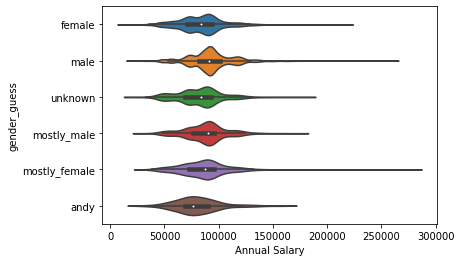

<IPython.core.display.Javascript object>

In [23]:
sns.violinplot("Annual Salary", "gender_guess", data=chicago)
plt.show()

Ah, of course, the very often forgotten gender, 'andy'.

Per documentation, andy is their shorthand for androgynous.  Let's collapse down to 3 categories: male, female, other.

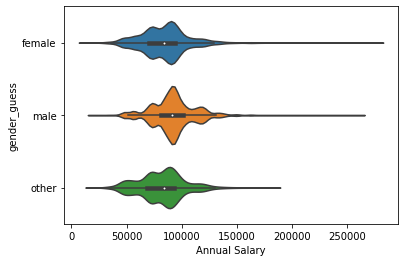

<IPython.core.display.Javascript object>

In [24]:
replacements = {
    "mostly_male": "male",
    "mostly_female": "female",
    "unknown": "other",
    "andy": "other",
}

chicago["gender_guess"] = chicago["gender_guess"].replace(replacements)

sns.violinplot("Annual Salary", "gender_guess", data=chicago)
plt.show()

In our plot we might be seeing a gender pay gap, with the biggest loser being... Andy.  At least Andy has Woody and Buzz to help cope.

💥BOOM 💥 new feature is now engineered.  Let's get back to some more on topic stuff.

Look at the value counts for `'Job Titles'` and `'Department'`.  Spoiler, there's a lot, create an 'other' category for both.  Decide some cutoff point for what's too few (threshold by count, threshold by count percentile, take the top n, etc.)

* Perform the process on one of the columns
* Translate this logic into a function
* Use your function on the other column

In [25]:
def make_other_cat(series, percentile=50, thresh=None):
    series_copy = series.copy()
    counts = series_copy.value_counts()

    if thresh is None:
        thresh = np.percentile(counts, percentile)

    below_thresh_names = counts[counts < thresh].index
    below_thresh_names

    series_copy[series_copy.isin(below_thresh_names)] = "other"

    return series_copy

<IPython.core.display.Javascript object>

In [26]:
chicago["Job Titles"] = make_other_cat(chicago["Job Titles"], 90)

<IPython.core.display.Javascript object>

In [27]:
chicago["Department"] = make_other_cat(chicago["Department"], 50)

<IPython.core.display.Javascript object>

## Model Prep

Perform a train test split stratified by our gender guess feature.

In [30]:
X = chicago.dropna().drop(columns=["Annual Salary"])
y = chicago.dropna()["Annual Salary"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=chicago["gender_guess"],
)

<IPython.core.display.Javascript object>

Our `X` data is all categories; let's use the `LeaveOneOutEncoder()`.  If we get poor performance we can come back and drop in a `OneHotEncoder()` with fairly little effort.

* Complete the `Pipeline`
    * Fill in the category encoder
    * Fill in the gradient boosted regressor
* Fit the pipeline to the training data
* Report the scores for the training and testing data

In [31]:
# fmt: off
pipeline = Pipeline([
    ("encode_cats", LeaveOneOutEncoder()),
    ("gbr", GradientBoostingRegressor())
])
# fmt: on

pipeline.fit(X_train, y_train)

train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print(f"train_score {train_score}")
print(f"test_score {test_score}")

train_score 0.42855354224411446
test_score 0.4202556949747164


<IPython.core.display.Javascript object>

In [32]:
from sklearn.metrics import mean_absolute_error


y_pred = pipeline.predict(X_test)
mean_absolute_error(y_test, y_pred)

11277.96647035942

<IPython.core.display.Javascript object>

A pretty smart guy said this is his parameter grid for this model type. (the names don't line up with sklearn's names).

<img src='https://i.stack.imgur.com/9GgQK.jpg' width='70%'>

* Grid search some hyperparams to increase performance
* Print out the best parameters from the CV

In [33]:
# Adjusted max_features/max_depth to have smaller grid
grid = {
    "gbr__subsample": [0.5, 0.75, 1.0],
    "gbr__max_features": [0.5, 0.75, 1.0],
    "gbr__max_depth": [5, 7, 9],
}

n_trees = 100
learning_rate = 2 / n_trees

# fmt: off
pipeline = Pipeline([
    ("encode_cats", LeaveOneOutEncoder()),
    ("gbr", GradientBoostingRegressor(n_estimators=n_trees, 
                                      learning_rate=learning_rate))
])
# fmt: on

pipeline_cv = GridSearchCV(pipeline, grid, verbose=1)
pipeline_cv.fit(X_train, y_train)

pipeline_cv.best_params_

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  1.9min finished


{'gbr__max_depth': 5, 'gbr__max_features': 1.0, 'gbr__subsample': 0.5}

<IPython.core.display.Javascript object>

Print out the train and test scores

In [34]:
train_score = pipeline_cv.score(X_train, y_train)
test_score = pipeline_cv.score(X_test, y_test)

print(f"train_score {train_score}")
print(f"test_score {test_score}")

train_score 0.4327432829206985
test_score 0.4220408038158011


<IPython.core.display.Javascript object>

Extract the `.feature_importances_` from the gbtree regressor in your pipeline.  What was most important?

In [36]:
importance_df = pd.DataFrame()

importance_df["feat"] = X_train.columns
importance_df["importance"] = pipeline_cv.best_estimator_["gbr"].feature_importances_
importance_df

,feat,importance
0,Job Titles,0.769767
1,Department,0.055760
2,gender_guess,0.174473


<IPython.core.display.Javascript object>